# Домашнее задание
## Реализация алгоритма Deep Feature Interpolation

### План

1. Изучите алгоритм, описанный в [статье](https://arxiv.org/pdf/1611.05507.pdf).
2. Скачайте датасет (`faces.tar`) и разархивируйте его.
3. Реализуйте алгоритм **Deep Feature Interpolation**.
4. Продемонстрируйте результаты работы на произвольном изображении.

### Критерии оценки

* реализация базового алгоритма (с демонстрацией работы на каком-нибудь изображении из выборки): **50 баллов**
* визуализация интерполяции (варьировать степень модификации изменением $\alpha$): **30 баллов**
* применить алгоритм к какой-нибудь картике не из выборки (с применением детектора и вставкой обратно): **20 баллов**

### Подсказки

* для экономии памяти предлагается хранить в индексе не сами вектора, а их проекции на меньшее пространство (например, в качестве базиса использовать top-256 PCA, посчитанный на 5К-10К объектах выборки), а когда нужно посчитать вектор-смещение, просто пересчитывать необходимое количество
* поэкспериментируйте со взвешиванием основного лосса и полной вариации
* экспериментируйте на изображениях меньшего разрешения (например, 64х64)

In [1]:
import gc
import os
import pickle
import sys

import numpy as np
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
import torch
import torch.nn as nn
import torchvision
from tqdm import tqdm, tqdm_notebook

import matplotlib.pyplot as plt
%matplotlib inline

IMAGE_SIZE = 128
gc.enable()

### Загрузка данных

*Предоставляемый датасет был размечен классификатором, поэтому может содержать большое количество ошибок. Тем не менее, для выполнения данного задания это не так критично.*

In [2]:
def load_dataset(directory):
    header = []
    labels = []
    filepaths = []
    
    with open(os.path.join(directory, 'gt.csv')) as f:
        header = f.readline().strip().split()[1:]
        header = [h.lower() for h in header]
        for line in f:
            fields = line.strip().split()
            path = os.path.join(directory, fields[0])
            filepaths.append(path)
            labels.append(fields[1:])

    return (
        header,
        np.array(labels),
        np.array(filepaths)
    )

DATASET_DIRECTORY_PATH = './data/faces'  
header, labels, filepaths = load_dataset(DATASET_DIRECTORY_PATH)

print(f"{len(filepaths)} изображений в датасете")

202278 изображений в датасете


In [3]:
print("Содержимое датасета по категориям:")
for i in range(len(header)):
    print(header[i], ":")
    names, counts = np.unique(labels[:, i], return_counts=True)
    for j in range(len(names)):
        print(" * ", names[j], ":", counts[j])

Содержимое датасета по категориям:
race :
 *  asian : 16215
 *  caucasian : 186063
gender :
 *  female : 134736
 *  male : 67542
age :
 *  adult : 75318
 *  old : 62429
 *  senior : 43973
 *  young : 20558
facial_hair :
 *  beard : 6689
 *  mustache : 2541
 *  shaved : 193048


In [4]:
# функция для удобного взаимодействия с разметкой

def get_mask(**kwargs):
    mask = np.ones(len(filepaths), dtype=np.bool)
    for h in kwargs:
        if isinstance(kwargs[h], list):
            mask &= np.in1d(labels[:, header.index(h)], kwargs[h])
        else:
            mask &= labels[:, header.index(h)] == kwargs[h]
    return mask

def load_image(path, size=(IMAGE_SIZE, IMAGE_SIZE)):
    img = Image.open(path)
    img = img.convert("RGB")
    img = img.resize(size, Image.BICUBIC)
    return img

# примеры запросов
print("count(asian & female) =", get_mask(race='asian', gender='female').sum())
print("count(caucasian & male & shaved) =", get_mask(race='caucasian', gender='male', facial_hair='shaved').sum())

count(asian & female) = 11046
count(caucasian & male & shaved) = 53359


### Функция $\phi(x)$

Определим функцию отображения в признаковое пространство в виде `nn.Module`:


In [178]:
class Phi(nn.Module):
    def __init__(self, pretrained=True):
        super(Phi, self).__init__()
        # копируем код с семинара ¯\_(ツ)_/¯
        model = torchvision.models.vgg19(pretrained=pretrained)
        layers = list(model.features)
        
        self.slice_0 = nn.Sequential(*layers[0:12])
        self.slice_1 = nn.Sequential(*layers[12:21])
        self.slice_2 = nn.Sequential(*layers[21:30])

        for param in self.parameters():
            param.requires_grad = False

    def forward(self, x):
        mean = x.new_tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = x.new_tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        x = (x - mean) / std
        
        xs = []

        x = self.slice_0(x)
        xs.append(x.view(x.shape[0], -1))
        
        x = self.slice_1(x)
        xs.append(x.view(x.shape[0], -1))
        
        x = self.slice_2(x)
        xs.append(x.view(x.shape[0], -1))
        return torch.cat(xs, dim=1)
    

to_tensor = torchvision.transforms.ToTensor()
to_image = torchvision.transforms.ToPILImage()

phi = Phi()

NameError: name 'x' is not defined

image_id:  30183
number of features per image:  torch.Size([425984])


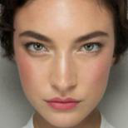

In [6]:
# пример использования

image_id = 30183#np.random.randint(filepaths.size)
print("image_id: ", image_id)
image = load_image(filepaths[image_id])
feature_space = phi(to_tensor(image).unsqueeze(0)).squeeze(0)

print("number of features per image: ", feature_space.shape)
image

### Построение индекса базы

Извлеките признаки (функцией $\phi$) из изображений базы. По этим признакам вы будете искать похожие изображения, поэтому можно хранить их сжатое представление.

In [7]:
with open("dumps/pca.pkl", "rb") as infile:
    pca = pickle.load(infile)

In [8]:
# np.random.seed(179)
# train_size = 5000 # тут было 20к, но потом стало всё время умирать ядро
# train_paths = np.random.choice(filepaths, size=train_size)
# train_feature_space = []

# batch_size = 1000
# for i in tqdm_notebook(range(0, train_size, batch_size), "batch"):
#     paths_batch = train_paths[i:i + batch_size]
#     train_images = torch.cat([to_tensor(load_image(path)).unsqueeze(0) 
#                               for path in tqdm_notebook(paths_batch, "reading batch")])
#     train_feature_space.append(phi(train_images).detach().numpy())
    
# train_feature_space = np.vstack(train_feature_space)        
# pca = PCA(n_components=128)
# pca.fit(train_feature_space)
# with open("dumps/pca.pkl", "wb") as outfile:
#     pickle.dump(pca, outfile, pickle.HIGHEST_PROTOCOL)
# print("reduced")
# gc.collect()


reduced


0

In [8]:
base_index = np.load("dumps/base_index.npy")

In [15]:
# base_index = []
# batch_size = 1000
# for i in tqdm_notebook(range(0, filepaths.size, batch_size), "batch"):
#     paths_batch = filepaths[i:i + batch_size]
#     batch = torch.cat([to_tensor(load_image(path)).unsqueeze(0) 
#                        for path in tqdm_notebook(paths_batch, "reading batch")])
#     feature_space = phi(batch).detach().numpy()
#     base_index.append(pca.transform(feature_space))
#     np.vstack(base_index).dump("dumps/base_index.npy")
    
# base_index = np.vstack(base_index)
# base_index.dump("dumps/base_index.npy")

### Функция подбора кандидатов

У нас есть база признаков, по которым мы можем искать изображения, похожие на запрос. Напишите функцию, которая для данного изображения `query` находит `n` наиболее похожих на него (по сжатому признаковому описанию) среди изображений, покрываемых бинарной маской `mask` (размер маски равен количеству изображений в базе). В качестве меры похожести можете использовать косинусную меру.

In [9]:
def best_similar(query_image, mask, n=100):
    query_feature_vec = pca.transform(
        phi(to_tensor(query_image).unsqueeze(0)).detach().numpy()
    ).reshape(1, -1)
    assert query_feature_vec.shape == (1, query_feature_vec.size)
    similarities = np.ravel(
        cosine_similarity(query_feature_vec,
                          base_index[mask])
    )
    mask_indices = np.nonzero(mask)[0]
    return mask_indices[np.argsort(similarities)[::-1][:n]]

neighbor_indices = best_similar(load_image(filepaths[30183]), 
                                get_mask(race="caucasian", gender="female"))

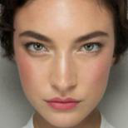

In [10]:
load_image(filepaths[30183])

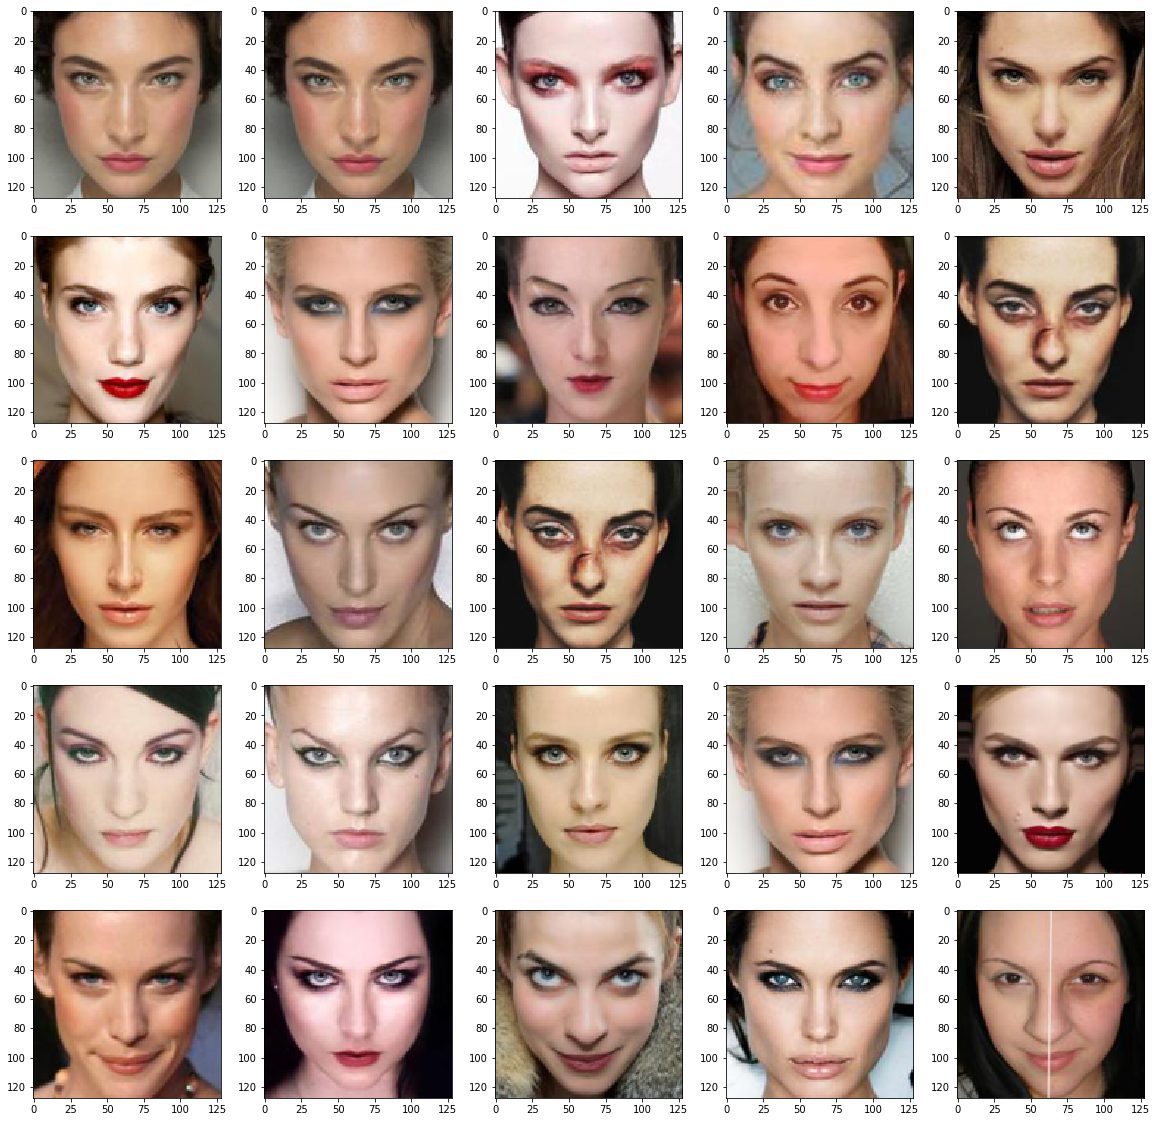

In [11]:
fig, axes = plt.subplots(5, 5, figsize=(20,20))
for i in range(5):
    for j in range(5):
        axes[i,j].imshow(load_image(
            filepaths[neighbor_indices[i*5+j]]
        ))

In [12]:
neighbor_indices = best_similar(load_image(filepaths[30183]), 
                                get_mask(race="asian", gender="female"))

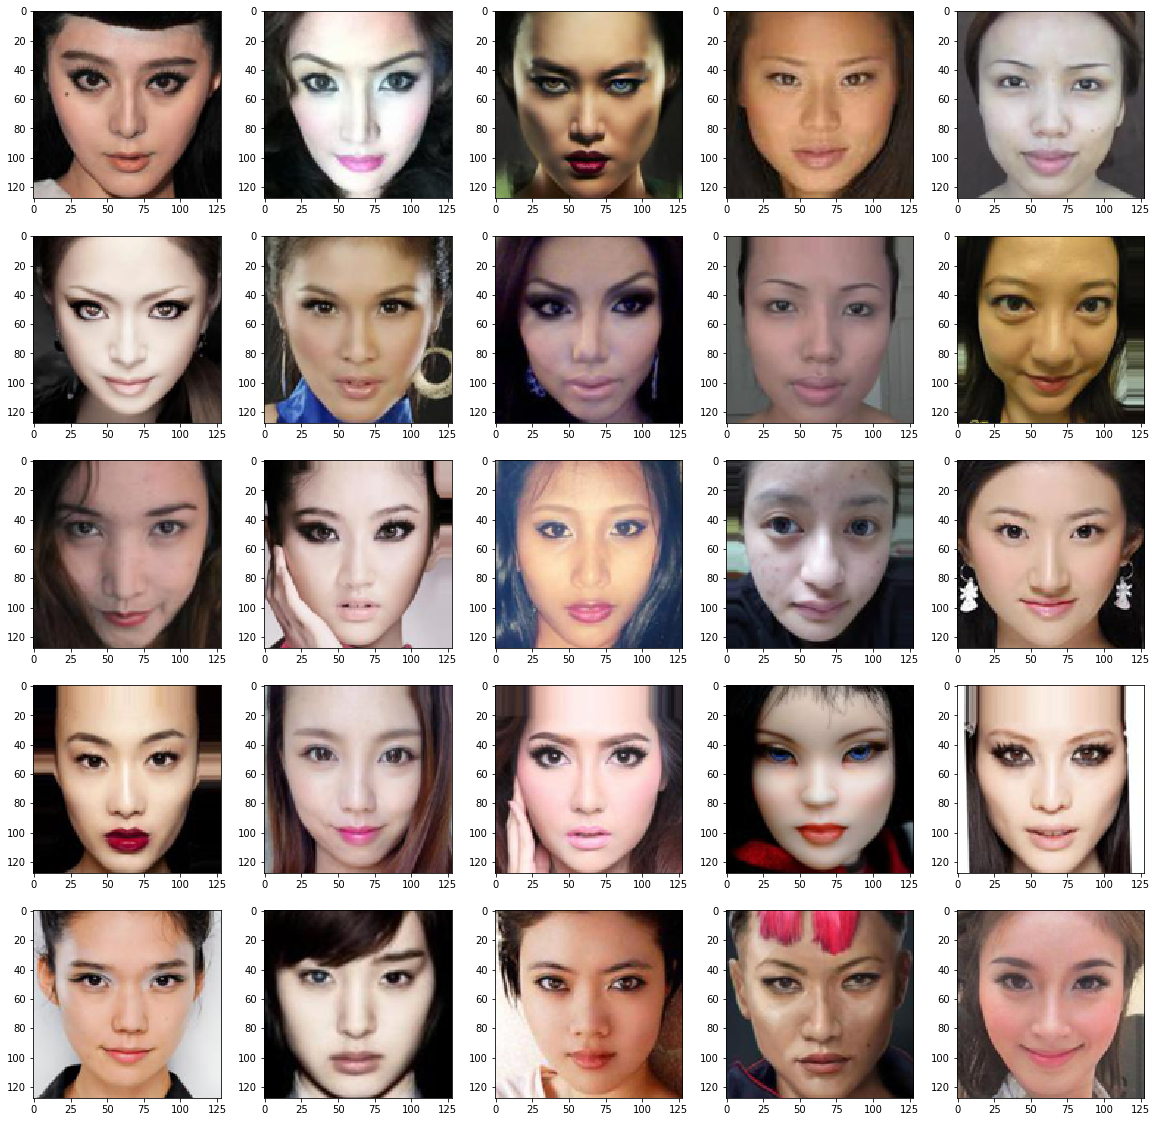

In [13]:
fig, axes = plt.subplots(5, 5, figsize=(20,20))
for i in range(5):
    for j in range(5):
        axes[i,j].imshow(load_image(
            filepaths[neighbor_indices[i*5+j]]
        ))

### Вычисление центров кластеров

Используя функцию `best_similar` реализуйте функцию подсчёта центров кластеров в признаковом пространстве $\phi$ изображений, наиболее похожих на изображение-запрос. С использованием этой функции вы сможете для двух различных наборов атрибутов (например `caucasian & male` и `asian & male`) вычислить вектор-смещение, по которому мы будем "двигать" признаковое описание оптимизируемого изображения. 

*Заметьте, что если мы будем производить модификацию из `caucasian & male` в `asian & male`, то изображение, которое мы оптимизируем, должно принадлежать множеству `caucasian & male`, иначе результат может получиться так себе.*

In [151]:
def centroid(query_image, mask):
    neighbor_indices = best_similar(query_image, mask)
    feature_vectors = torch.cat([
        phi(to_tensor(load_image(path)).unsqueeze(0)) 
        for path in tqdm_notebook(filepaths[neighbor_indices], "neighbors")
    ])
    return feature_vectors.mean(dim=0)

### Функция потерь

Реализуйте функцию потерь, которую мы будем минимизировать для выбранного изображения и вычисленного для него вектора смещения.

In [159]:
cuda0 = torch.device('cuda:1')

In [160]:
class TVLoss(nn.Module):
    def __init__(self, eps=1e-3, beta=2):
        super(TVLoss, self).__init__()
        self.eps = eps
        self.beta = beta

    def forward(self, image_tensor):
        x_diff = image_tensor[:, :, :-1, :-1] - image_tensor[:, :, :-1, 1:]
        y_diff = image_tensor[:, :, :-1, :-1] - image_tensor[:, :, 1:, :-1]

        sq_diff = torch.clamp(x_diff * x_diff + y_diff * y_diff, self.eps, 10000000)
        return torch.norm(sq_diff, self.beta / 2.0) ** (self.beta / 2.0)
    
criterion_mse = nn.MSELoss().cuda()
criterion_tv = TVLoss().cuda()

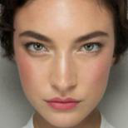

In [149]:
test_image = load_image(filepaths[30183])
test_image

In [146]:
phi.zero_grad()
test_image_tensor = to_tensor(test_image).unsqueeze(0).requires_grad_(True)
target_feature_tensor = phi(test_image_tensor)
target_feature_tensor += torch.rand_like(target_feature_tensor)
loss = criterion_mse(target_feature_tensor, phi(test_image_tensor))
print(loss.grad is None)
print(loss)
# plt.imshow(
#     make_optimizer_step(target_feature_tensor, 
#                         test_image_tensor)\
#     .squeeze(0)\
#     .permute(1,2,0)
# )

True
tensor(0.3334, grad_fn=<MeanBackward1>)


### Оптимизиация

Напишите код оптимизации изображения с использованием какого-нибудь оптимизатора.

In [189]:
# ваш код + визуализация результата
def make_optimizer_step(target_feature_tensor, image_tensor):
    opt_image = nn.Parameter(image_tensor, requires_grad=True)
    # кладём в оптимизатор (здесь лучше использовать L-BFGS)
    optimizer = torch.optim.LBFGS([opt_image], max_iter=500)
    for t in tqdm(range(1)):

        # L-BFGS требует определить функции, которая
    #     возращает функцию потерь и считает градиенты
        def closure():
            optimizer.zero_grad()
            loss = calc_loss(target_feature_tensor, opt_image)
#             loss.backward()
            return loss

        loss = optimizer.step(closure)
    #     # не забываем клипать изображение!
        opt_image.data.clamp_(0, 1)

    # "вырываем" тензор из графа
    return opt_image.detach()

In [202]:
test_image = load_image(filepaths[30183])

asian_female_mask = get_mask(race="asian", gender="female")
white_female_mask = get_mask(race="caucasian", gender="female")

phi_t = centroid(test_image, asian_female_mask)
phi_s = centroid(test_image, white_female_mask)

In [216]:
phi_t.to(cuda0)
phi_s.to(cuda0)

def morph_image(x, alpha=15, lambd = 0.05, verbose=False):
    x = x.to(cuda0)
    phi.to(cuda0)
    # инициализируем оптимизируемое изображение
    # из изображения контента, помечаем его как "оптимизируемое"
    x_o = x.clone().requires_grad_()

    # кладём в оптимизатор (здесь лучше использовать L-BFGS)
    optimizer = torch.optim.LBFGS([x_o])
    w = phi_t - phi_s
    w = w.to(cuda0)
    phi_z = phi(x) + alpha * w
    
    for t in tqdm_notebook(range(100)):

        def closure():
            optimizer.zero_grad()
            loss = 0.5 * criterion_mse(phi_z, phi(x_o)) + lambd * criterion_tv(x_o)
            loss.backward()
            return loss
    
        loss = optimizer.step(closure)
        if not t % 10 and verbose:
            print(loss.item())
        # не забываем клипать изображение!
        x_o.data.clamp_(0, 1)
    phi.cpu()
    # "вырываем" тензор из графа
    return x_o.detach().cpu()

phi_t.cpu()
phi_s.cpu()

out_image = change_image(to_tensor(test_image).unsqueeze(0))

7.264199256896973
3.3809127807617188
3.352339029312134
3.3396246433258057
3.3316431045532227
3.326484441757202
3.322512626647949
3.319244861602783
3.316605567932129
3.314422369003296


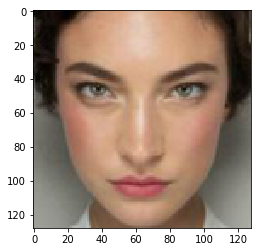

In [217]:
plt.imshow(to_tensor(test_image).squeeze(0).permute(1,2,0))

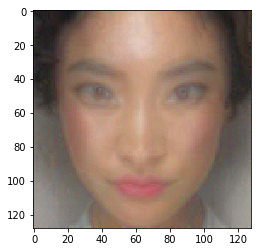

In [218]:
plt.imshow(out_image.squeeze(0).permute(1,2,0))

### Устранение артефактов (желательно)

В результате оптимизации на изображении могут появиться нежелательные артифакты в виде смещения цетовой палитры. Попробуйте побороть это вычитанием из результата разницы между исходным изображением и модифицированным изображением с параметром $\alpha=0$.

In [219]:
# ваш код + визуализация результата

test_image_tensor = to_tensor(test_image).unsqueeze(0)
color_noise = test_image_tensor - change_image(test_image_tensor, alpha=0)

5.962012767791748
2.7961323261260986
2.7741434574127197
2.764446496963501
2.7585277557373047
2.7544186115264893
2.7509686946868896
2.7482709884643555
2.7459194660186768
2.7439703941345215


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


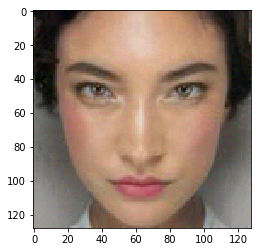

In [220]:
plt.imshow((out_image + color_noise).squeeze(0).permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


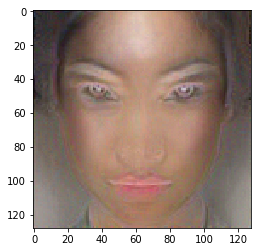

In [221]:
plt.imshow((out_image - color_noise).squeeze(0).permute(1,2,0))

### Интерполяция в признаковом пространстве (бонус)

Постройте последовательность изображений с варьированием степени модификации.

In [222]:
morphed_lst = []
alpha_lst = [3, 5, 7, 10, 15, 30]
for alpha in alpha_lst:
    morphed_lst.append(change_image(test_image_tensor, alpha=alpha))

8.891932487487793
4.195474147796631
4.158151149749756
4.142897605895996
4.13329553604126
4.126862525939941
4.122247695922852
4.118093490600586
4.1149067878723145
4.112326622009277


14.100679397583008
6.9992570877075195
6.937557220458984
6.912100791931152
6.89726448059082
6.886240482330322
6.8762664794921875
6.867436408996582
6.859345436096191
6.851415157318115


21.913799285888672
11.759268760681152
11.655072212219238
11.605823516845703
11.571732521057129
11.546269416809082
11.525932312011719
11.5089693069458
11.49181079864502
11.477269172668457


38.51668167114258
23.069841384887695
22.873653411865234
22.789722442626953
22.733375549316406
22.683080673217773
22.642724990844727
22.606115341186523
22.555997848510742
22.498409271240234


79.21001434326172
53.667625427246094
53.20597839355469
52.996482849121094
52.839115142822266
52.66203689575195
52.3272590637207
54.77769470214844
59.93672180175781
63.25732421875


298.9540100097656
236.01577758789062
239.69192504882812
243.2925262451172
248.64523315429688
253.1075439453125
257.0047302246094
260.50555419921875
263.67730712890625
263.7472839355469


In [223]:
len(morphed_lst)

6

### Работа с изображениями не из базы (бонус)

Ниже приведена функция `get_face_bbox`, которая возращает координаты для кропа лица из изображения. Используйте её, чтобы вырезать изображение лица, произвести над ним какую-нибудь трансформацию (например, смена пола или расы), а затем вставить модифицированное изображение обратно.

In [ ]:
import cv2


HAAR_CASCADE_FILEPATH = './data/haarcascade_frontalface_default.xml'
cascade = cv2.CascadeClassifier(HAAR_CASCADE_FILEPATH)

def get_face_bbox(image):
    faces = cascade.detectMultiScale(
        np.asarray(image),
        scaleFactor=1.3,
        minNeighbors=5,
        minSize=(50, 50),
        flags=cv2.CASCADE_SCALE_IMAGE)
    if len(faces) != 1:
        return None
    x, y, w, h = faces[0]
    return x, y, x + w, y + h

In [ ]:
# ваш код + визуализация результата